# Spam Filter Prediction

In [1]:
# # Spam Filter In Python3 and Python4
from nltk.tokenize import word_tokenize
from nltk.corpus import stopwords
from nltk.stem import PorterStemmer
import matplotlib.pyplot as plt 
from wordcloud import WordCloud 
from math import log,sqrt
import pandas as pd 
import numpy as np 
import tkinter
from tkinter import messagebox

In [2]:
# # loading the dataset in the mails
mails=pd.read_csv('spam.csv',encoding='latin-1')

In [3]:
mails.drop(['Unnamed: 2','Unnamed: 3','Unnamed: 4'],axis=1,inplace=True)

In [4]:
mails.rename(columns={'v1':'labels','v2':'text'},inplace=True)

In [5]:
# # now we will be going to count the mails according to the labels
mails['labels'].value_counts()

ham     4825
spam     747
Name: labels, dtype: int64

In [6]:
mails['label']=mails['labels'].map({'ham':0,'spam':1})

In [7]:
mails.drop(['labels'],axis=1,inplace=True)

In [8]:
totalMails=4825+747
trainIndex,testIndex=list(),list()
for i in range(mails.shape[0]):
    if np.random.uniform(0,1)<0.75:
        trainIndex+=[i]
    
    else:
        testIndex+=[i]

In [9]:
trainData=mails.loc[trainIndex]
testData=mails.loc[testIndex]
trainData.reset_index(inplace=True)
trainData.drop(['index'],axis=1,inplace=True)

In [10]:
testData.reset_index(inplace=True)
testData.drop('index',axis=1,inplace=True)

In [11]:
trainData['label'].value_counts()

0    3629
1     554
Name: label, dtype: int64

In [12]:
testData['label'].value_counts()

0    1196
1     193
Name: label, dtype: int64

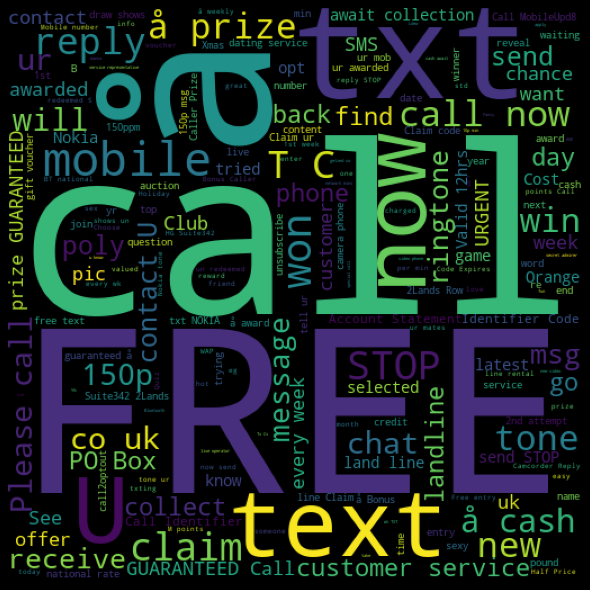

In [13]:
spam_words=''.join(list(mails[mails['label']==1]['text']))
spam_wc=WordCloud(width=512,height=512).generate(spam_words)
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(spam_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

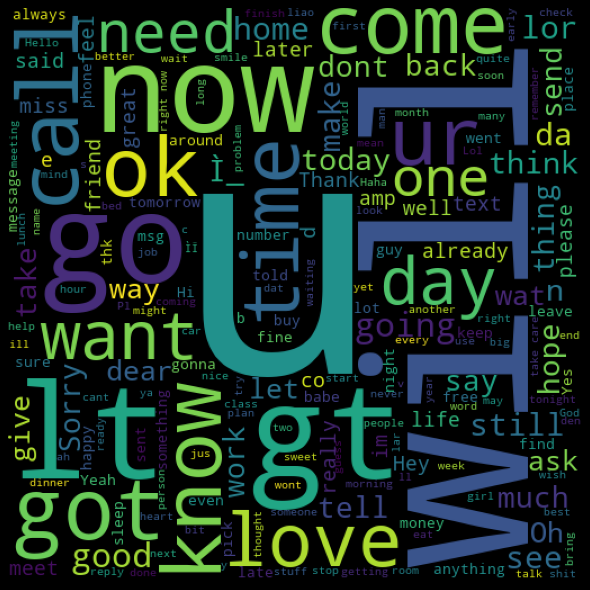

In [14]:
#doing the same thing for the ham words too
ham_words=''.join(list(mails[mails['label']==0]['text']))
ham_wc=WordCloud(width=512,height=512).generate(ham_words)
plt.figure(figsize=(10,8),facecolor='k')
plt.imshow(ham_wc)
plt.axis('off')
plt.tight_layout(pad=0)
plt.show()

In [15]:
def process_message(text, lower_case = True, stem = True, stop_words = True, gram = 2):
    if lower_case:
        text = text.lower()
    words = word_tokenize(text)
    words = [w for w in words if len(w) > 2]
    if gram > 1:
        w = []
        for i in range(len(words) - gram + 1):
            w += [' '.join(words[i:i + gram])]
        return w
    if stop_words:
        sw = stopwords.words('english')
        words = [word for word in words if word not in sw]
    if stem:
        stemmer = PorterStemmer()
        words = [stemmer.stem(word) for word in words]   
    return words

In [16]:
class SpamClassifier(object):
    def __init__(self, trainData, method = 'tf-idf'):
        self.mails, self.labels = trainData['text'], trainData['label']
        self.method = method

    def train(self):
        self.calc_TF_and_IDF()
        if self.method == 'tf-idf':
            self.calc_TF_IDF()
        else:
            self.calc_prob()

    def calc_prob(self):
        self.prob_spam =dict()
        self.prob_ham = dict()
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word] + 1) / (self.spam_words + \
                                                                len(list(self.tf_spam.keys())))
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word] + 1) / (self.ham_words + \
                                                                len(list(self.tf_ham.keys())))
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 


    def calc_TF_and_IDF(self):
        noOfMessages = self.mails.shape[0]
        self.spam_mails, self.ham_mails = self.labels.value_counts()[1], self.labels.value_counts()[0]
        self.total_mails = self.spam_mails + self.ham_mails
        self.spam_words = 0
        self.ham_words = 0
        self.tf_spam = dict()
        self.tf_ham = dict()
        self.idf_spam = dict()
        self.idf_ham = dict()
        for i in range(noOfMessages):
            message_processed = process_message(self.mails[i])
            count = list() #To keep track of whether the word has ocured in the message or not.
                           #For IDF
            for word in message_processed:
                if self.labels[i]:
                    self.tf_spam[word] = self.tf_spam.get(word, 0) + 1
                    self.spam_words += 1
                else:
                    self.tf_ham[word] = self.tf_ham.get(word, 0) + 1
                    self.ham_words += 1
                if word not in count:
                    count += [word]
            for word in count:
                if self.labels[i]:
                    self.idf_spam[word] = self.idf_spam.get(word, 0) + 1
                else:
                    self.idf_ham[word] = self.idf_ham.get(word, 0) + 1

    def calc_TF_IDF(self):
        self.prob_spam = dict()
        self.prob_ham = dict()
        self.sum_tf_idf_spam = 0
        self.sum_tf_idf_ham = 0
        for word in self.tf_spam:
            self.prob_spam[word] = (self.tf_spam[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam[word] + self.idf_ham.get(word, 0)))
            self.sum_tf_idf_spam += self.prob_spam[word]
        for word in self.tf_spam:
            self.prob_spam[word] = (self.prob_spam[word] + 1) / (self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
            
        for word in self.tf_ham:
            self.prob_ham[word] = (self.tf_ham[word]) * log((self.spam_mails + self.ham_mails) \
                                                          / (self.idf_spam.get(word, 0) + self.idf_ham[word]))
            self.sum_tf_idf_ham += self.prob_ham[word]
        for word in self.tf_ham:
            self.prob_ham[word] = (self.prob_ham[word] + 1) / (self.sum_tf_idf_ham + len(list(self.prob_ham.keys())))
            
    
        self.prob_spam_mail, self.prob_ham_mail = self.spam_mails / self.total_mails, self.ham_mails / self.total_mails 
                    
    def classify(self, processed_message):
        pSpam, pHam = 0, 0
        for word in processed_message:                
            if word in self.prob_spam:
                pSpam += log(self.prob_spam[word])
            else:
                if self.method == 'tf-idf':
                    pSpam -= log(self.sum_tf_idf_spam + len(list(self.prob_spam.keys())))
                else:
                    pSpam -= log(self.spam_words + len(list(self.prob_spam.keys())))
            if word in self.prob_ham:
                pHam += log(self.prob_ham[word])
            else:
                if self.method == 'tf-idf':
                    pHam -= log(self.sum_tf_idf_ham + len(list(self.prob_ham.keys()))) 
                else:
                    pHam -= log(self.ham_words + len(list(self.prob_ham.keys())))
            pSpam += log(self.prob_spam_mail)
            pHam += log(self.prob_ham_mail)
        return pSpam >= pHam
    
    def predict(self, testData):
        result = dict()
        for (i, message) in enumerate(testData):
            processed_message = process_message(message)
            result[i] = int(self.classify(processed_message))
        return result

In [17]:
def metrics(labels, predictions):
    true_pos, true_neg, false_pos, false_neg = 0, 0, 0, 0
    for i in range(len(labels)):
        true_pos += int(labels[i] == 1 and predictions[i] == 1)
        true_neg += int(labels[i] == 0 and predictions[i] == 0)
        false_pos += int(labels[i] == 0 and predictions[i] == 1)
        false_neg += int(labels[i] == 1 and predictions[i] == 0)
    precision = true_pos / (true_pos + false_pos)
    recall = true_pos / (true_pos + false_neg)
    Fscore = 2 * precision * recall / (precision + recall)
    accuracy = (true_pos + true_neg) / (true_pos + true_neg + false_pos + false_neg)

    print("Precision: ", precision)
    print("Recall: ", recall)
    print("F-score: ", Fscore)
    print("Accuracy: ", accuracy)

root = tkinter.Tk()
root.withdraw()

''

In [18]:
def alldonewithflyingcolors(pm,new):
    if sc_tf_idf.classify(pm)==True:
        #ctypes.windll.user32.MessageBoxW(0,'Alert')
        # print('AlertIt is a spam email')
        #tkMessageBox.showinfo('alert')
        messagebox.showwarning("Message Passed to Spam Filter Model",message=new)
        messagebox.showerror("Alert",message="Answer==Spam Email")
        #messagebox.ABORT()
    else:
        messagebox.showwarning("Message Passed to Spam Filter Model",message=new)
        messagebox.showinfo("Good News",message="Answer==Good Email")

In [19]:
import nltk
nltk.download('punkt')

[nltk_data] Downloading package punkt to
[nltk_data]     C:\Users\nagab\AppData\Roaming\nltk_data...
[nltk_data]   Package punkt is already up-to-date!


True

In [20]:
sc_tf_idf=SpamClassifier(trainData,'tf-idf')
sc_tf_idf.train()
preds_tf_idf=sc_tf_idf.predict(testData['text'])
metrics(testData['label'],preds_tf_idf)
#%% [markdown]
sc_bow=SpamClassifier(trainData,'bow')
sc_bow.train()
preds_bow=sc_bow.predict(testData['text'])
metrics(testData['label'],preds_bow)

Precision:  0.9215686274509803
Recall:  0.7305699481865285
F-score:  0.815028901734104
Accuracy:  0.9539236861051116
Precision:  0.92
Recall:  0.5958549222797928
F-score:  0.7232704402515723
Accuracy:  0.9366450683945284


In [21]:
new='I cant pick the phone'
pm=process_message(new)
print("The new message in the dataset"+str(pm))

The new message in the dataset['cant pick', 'pick the', 'the phone']


In [22]:
alldonewithflyingcolors(pm,new)
new='Congratulations you are awarded $500'
pm=process_message(new)
print(pm)

['congratulations you', 'you are', 'are awarded', 'awarded 500']


In [23]:
alldonewithflyingcolors(pm,new)
#%% [markdown]
new='Its is a new spam message'
pm=process_message(new)

In [24]:
new='Thanks for your subscription to Ringtone UK your mobile will be charged �5/month Please confirm by replying YES or NO. If you reply NO you will not be charged,,,'
pm=process_message(new)
alldonewithflyingcolors(pm,new)

In [25]:
new='This msg is for your mobile content order It has been resent as previous attempt failed due to network error Queries to customersqueries@netvision.uk.com,,,'
pm=process_message(new)
alldonewithflyingcolors(pm,new)

In [26]:
new='Money reward $500'
pm=process_message(new)
alldonewithflyingcolors(pm,new)

In [27]:
new='I am giving you 500$'
pm=process_message(new)
alldonewithflyingcolors(pm,new)

In [28]:
new='I am Rahul Chandra going to give you 500$ as a credit '
pm=process_message(new)
alldonewithflyingcolors(pm,new)